# Performing the bilinear system identification using the split-op propagator

The propagation follows [absorbing_boundary.ipynb](https://github.com/dibondar/QuantumClassicalDynamics/blob/master/absorbing_boundary.ipynb)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('') + '/QuantumClassicalDynamics')

from QuantumClassicalDynamics.imag_time_propagation import ImgTimePropagation, np, fftpack

from numba import njit # compile python
from scipy.signal import blackman
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # enable log color plot

In [2]:
from bi_sys_id_quantum import estimate_rank, bi_sys_id_my_version, get_response, get_training_responses

In [3]:
# Define parameters of an atom (a single-electron model of Ar) in the external laser field

# laser field frequency
omega_laser = 0.06

# the final time of propagation (= 8 periods of laser oscillations)
t_final = 8 * 2. * np.pi / omega_laser

# amplitude of the laser field strength
F = 0.04

# the amplitude of grid
x_amplitude = 100.

# the time step
dt = 0.05

@njit
def laser(t):
    """
    The strength of the laser field.
    Always add an envelop to the laser field to avoid all sorts of artifacts.
    We use a sin**2 envelope, which resembles the Blackman filter
    """
    return F * np.sin(omega_laser * t) * np.sin(np.pi * t / t_final) ** 2

@njit
def v(x, t=0.):
    """
    Potential energy.
    
    Define the  potential energy as a sum of the soft core Columb potential
    and the laser field interaction in the dipole approximation.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) + x * laser(t)

@njit
def diff_v(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5) + laser(t)

@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
                                                
@njit
def diff_k(p, t=0.):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p

@njit
def abs_boundary(x):
    """
    Absorbing boundary similar to the Blackman filter
    """
    return np.sin(0.5 * np.pi * (x + x_amplitude) / x_amplitude) ** (0.05 * dt)


sys_params = dict(
    dt=dt,
    x_grid_dim=1024,
    x_amplitude=x_amplitude,
    
    k=k,
    diff_k=diff_k,
    v=v,
    diff_v=diff_v,
    
    abs_boundary=abs_boundary,
)

In [4]:

#########################################################################
#
#   Define functions for testing and visualizing
#
#########################################################################


def test_propagation(sys, iterations=None):
    """
    Run tests for the specified propagators and plot the probability density
    of the time dependent propagation
    :param sys: class that propagates
    """
    # Set the ground state wavefunction as the initial condition
    sys.get_stationary_states(1)
    sys.set_wavefunction(sys.stationary_states[0])

    iterations = iterations if iterations else 748
    # steps = int(round(t_final / sys.dt / iterations))
    steps = 1
    
    # display the propagator
    extent=[sys.x.min(), sys.x.max(), 0., sys.t]
    
    plt.imshow(
        [np.abs(sys.propagate(steps)) ** 2 for _ in range(iterations)],
        origin='lower',
        norm=LogNorm(vmin=1e-12, vmax=0.1),
        #extent=extent,
        aspect=50,#aspect=((extent[-1] - extent[-2]) / (extent[1] - extent[0]))
        
    )
    plt.xlabel('coordinate $x$ (a.u.)')
    plt.ylabel('time $t$ (a.u.)')
    #plt.colorbar()


def test_Ehrenfest1(sys):
    """
    Test the first Ehenfest theorem for the specified quantum system
    """
    times = sys.dt * np.arange(len(sys.x_average))

    dx_dt = np.gradient(sys.x_average, sys.dt)

    print("{:.2e}".format(np.linalg.norm(dx_dt - sys.x_average_rhs)))

    plt.plot(times, dx_dt, '-r', label='$d\\langle\\hat{x}\\rangle / dt$')
    plt.plot(times, sys.x_average_rhs, '--b', label='$\\langle\\hat{p}\\rangle$')
    plt.legend()
    plt.ylabel('momentum')
    plt.xlabel('time $t$ (a.u.)')


def test_Ehrenfest2(sys):
    """
    Test the second Ehenfest theorem for the specified quantum system
    """
    times = sys.dt * np.arange(len(sys.p_average))

    dp_dt = np.gradient(sys.p_average, sys.dt)

    print("{:.2e}".format(np.linalg.norm(dp_dt - sys.p_average_rhs)))

    plt.plot(times, dp_dt, '-r', label='$d\\langle\\hat{p}\\rangle / dt$')
    plt.plot(times, sys.p_average_rhs, '--b', label='$\\langle -U\'(\\hat{x})\\rangle$')
    plt.legend()
    plt.ylabel('force')
    plt.xlabel('time $t$ (a.u.)')

In [5]:

#########################################################################
#
#   Declare the propagators
#
#########################################################################

# sys_no_abs_boundary = ImgTimePropagation(**sys_params)



sys_with_abs_boundary = ImgTimePropagation(
    **sys_params
)


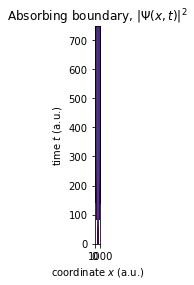

In [6]:

#########################################################################
#
# Test propagation in the context of High Harmonic Generation
#
#########################################################################

#plt.subplot(121)
#plt.title("No absorbing boundary, $|\\Psi(x, t)|^2$")
#test_propagation(sys_no_abs_boundary)

#plt.subplot(122)
plt.title("Absorbing boundary, $|\\Psi(x, t)|^2$")
test_propagation(sys_with_abs_boundary)

plt.show()


With absorbing boundary error in the first Ehrenfest relation: 
8.23e-06


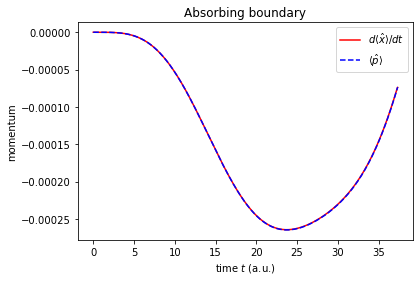


With absorbing boundary error in the second Ehrenfest relation: 
1.46e-07


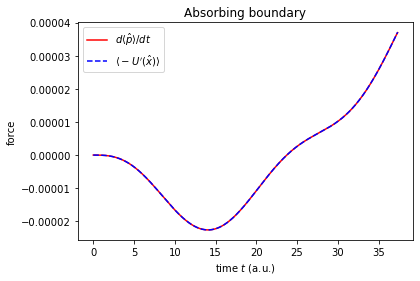

In [7]:
#plt.subplot(221)
#plt.title("No absorbing boundary")
#print("\nNo absorbing boundary error in the first Ehrenfest relation: ")
#test_Ehrenfest1(sys_no_abs_boundary)

#plt.subplot(222)
#plt.title("No absorbing boundary")
#print("\nNo absorbing boundary error in the second Ehrenfest relation: ")
#test_Ehrenfest2(sys_no_abs_boundary)

#plt.subplot(223)
plt.title("Absorbing boundary")
print("\nWith absorbing boundary error in the first Ehrenfest relation: ")
test_Ehrenfest1(sys_with_abs_boundary)

plt.show()

#plt.subplot(224)
plt.title("Absorbing boundary")
print("\nWith absorbing boundary error in the second Ehrenfest relation: ")
test_Ehrenfest2(sys_with_abs_boundary)

plt.show()

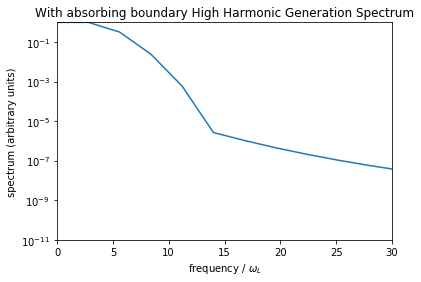

In [8]:

def plot_spectrum(sys):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    N = len(sys.p_average_rhs)
    k = np.arange(N)

    # frequency range
    omegas = (k - N / 2) * np.pi / (0.5 * sys.t)

    # spectra of the
    spectrum = np.abs(
        # used windows fourier transform to calculate the spectra
        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
        fftpack.fft((-1) ** k * blackman(N) * sys.p_average_rhs)
    ) ** 2
    spectrum /= spectrum.max()

    plt.semilogy(omegas / omega_laser, spectrum)
    plt.ylabel('spectrum (arbitrary units)')
    plt.xlabel('frequency / $\\omega_L$')
    plt.xlim([0, 30.])
    plt.ylim([1e-11, 1.])

#plt.subplot(121)
#plt.title("No absorbing boundary High Harmonic Generation Spectrum")
#plot_spectrum(sys_no_abs_boundary)

#plt.subplot(122)
plt.title("With absorbing boundary High Harmonic Generation Spectrum")
plot_spectrum(sys_with_abs_boundary)

plt.show()

# Generate responces for system identification

In [9]:
# system parameters without the potential energy laser field
common_sys_params = dict(
        dt=dt,
        x_grid_dim=1024,
        x_amplitude=x_amplitude,

        k=k,
        diff_k=diff_k,
        
        abs_boundary=abs_boundary,
)

# amplitude of the laser field strength
F = 0.05

@njit
def v_pulse_off(x, t=0.):
    """
    Potential energy with field off.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) 

@njit
def diff_v_pulse_off(x, t=0.):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5)

@njit
def v_pulse_on(x, t=0.):
    """
    Potential energy with field on.
    """
    return v_pulse_off(x) + x * F

@njit
def diff_v_pulse_on(x, t=0.):
    """
    the derivative of the potential energy
    """
    return diff_v_pulse_off(x) + F

# get the ground state
sys = ImgTimePropagation(
    v = v_pulse_off,
    **common_sys_params
)
sys.get_stationary_states(1)
ground_state = sys.stationary_states[0]


control_off_tsteps = 1000

orig_responces = []

for control_on_tsteps in range(1, 100):
    
    # propagate with field on
    sys = ImgTimePropagation(
        v = v_pulse_on,
        diff_v = diff_v_pulse_on,
        **common_sys_params
    ).set_wavefunction(ground_state)
    
    # save the initial point
    sys.get_ehrenfest()
    
    displaced_state = sys.propagate(control_on_tsteps)

    response_field_on = sys.p_average
    
    # propagate with field off
    sys = ImgTimePropagation(
        v = v_pulse_off,
        diff_v = diff_v_pulse_off,
        **common_sys_params
    ).set_wavefunction(displaced_state)

    sys.propagate(control_off_tsteps - control_on_tsteps - 1)
    
    # save the output with the fild on and off
    orig_responces.append(
        response_field_on + sys.p_average
    )

In [10]:
orig_responces = np.array(orig_responces)

In [11]:
# times of propagation
times = dt * np.arange(orig_responces.shape[1])

In [12]:
rank, sigma = estimate_rank(np.array(orig_responces), alpha=int(orig_responces.shape[1] / 2))

Estimated rank  5
[5.73162917e-01 5.18976035e-01 2.20315674e-02 1.87125459e-02
 2.33827033e-03 9.10030062e-04 1.29772411e-04 5.86347381e-05
 8.57473642e-06 2.42967195e-06 1.25938197e-07 1.05799113e-08
 4.47666670e-09 1.96342874e-09 3.75176438e-10 3.68800153e-10
 2.01898359e-10 1.92519626e-10 1.26643085e-10 1.20885568e-10
 8.61467750e-11 8.34540266e-11 6.18346078e-11 6.15946790e-11
 5.23078051e-11 4.61116915e-11 4.50824361e-11 3.55770481e-11
 3.53696979e-11 2.83279072e-11 2.77195909e-11 2.28042153e-11
 2.20940971e-11 1.85240011e-11 1.78532486e-11 1.51636458e-11
 1.45918510e-11 1.25033801e-11 1.20534638e-11 1.03795702e-11
 1.00687501e-11 8.66220408e-12 8.52099130e-12 7.33749388e-12
 7.25976006e-12 6.43703446e-12 6.11743673e-12 5.61743364e-12
 5.18352832e-12 4.85529839e-12 4.40619599e-12 4.19414537e-12
 3.76023422e-12 3.63538381e-12 3.21966637e-12 3.18057940e-12
 3.16741695e-12 2.76187913e-12 2.76109782e-12 2.42253501e-12
 2.38780380e-12 2.10773046e-12 2.06145203e-12 1.84127090e-12
 1.780

(0, 20)

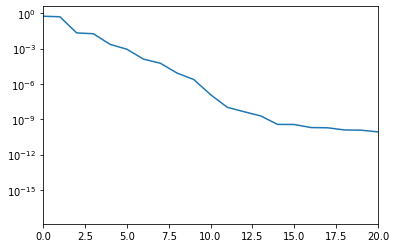

In [13]:
plt.semilogy(sigma)
plt.xlim([0, 20])

In [14]:
reconstructed = bi_sys_id_my_version(
    orig_responces,
    alpha = int(orig_responces.shape[1] / 2),
    dt = dt,
    v = [F],
    #rank = 10
)

In [15]:
reconstructed_responses = get_training_responses(reconstructed, times=times, p=orig_responces.shape[0], u=F)

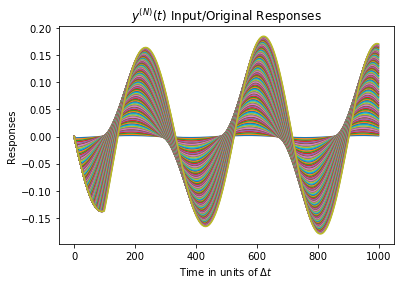

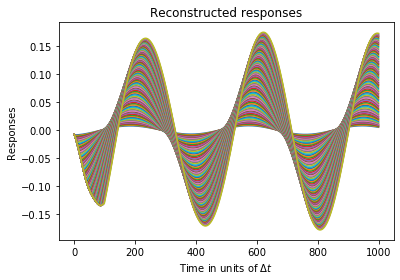

In [16]:
plt.title("$y^{(N)}(t)$ Input/Original Responses")
plt.plot(orig_responces.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("Responses")
plt.savefig('input.pdf')
plt.show()


plt.title("Reconstructed responses")
plt.plot(reconstructed_responses.T)
plt.xlabel("Time in units of $\Delta t$")
plt.ylabel("Responses")
plt.savefig('reproduction.pdf')
plt.show()

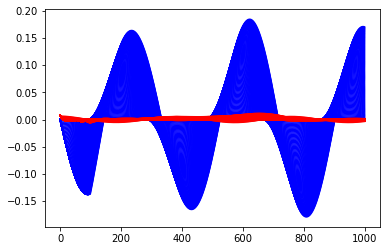

In [17]:
plt.plot(orig_responces.T, 'b')
plt.plot(orig_responces.T - reconstructed_responses.T, 'r')
#plt.xlim([0, 100])
plt.show()

In [18]:
eigvals(reconstructed.Ac)

array([-0.04796435+0.47492551j, -0.04796435-0.47492551j,
       -0.00085683+0.33236148j, -0.00085683-0.33236148j,
       -0.08083277+0.j        ])

In [19]:
eigvals(reconstructed.Nc[0])

array([ 46.58785491+56.89761015j,  46.58785491-56.89761015j,
       -27.59626851 +0.j        ,   1.23375573 +1.2851033j ,
         1.23375573 -1.2851033j ])

In [20]:

check_pulse = njit(lambda t: 0.01 * F * np.sin(1 * t))

In [21]:
response = get_response(reconstructed, check_pulse, times)

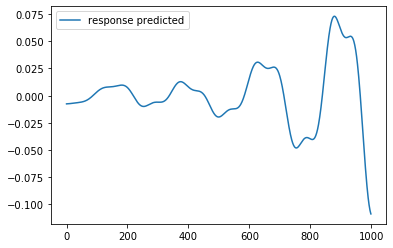

In [22]:
plt.plot(response, label='response predicted')
#plt.plot(check_pulse(times), label='field')
#plt.ylim([-0.1, 0.1])
#plt.xlim([0, 20])
plt.legend()
plt.show()

In [23]:
sys = ImgTimePropagation(
    v = njit(
        lambda x, t: v_pulse_off(x) + x * check_pulse(t)
    ),
    diff_v = njit(
        lambda x, t: diff_v_pulse_off(x) + check_pulse(t)
    ),
    **common_sys_params
).set_wavefunction(ground_state)

sys.propagate(times.size)

array([0.00000000e+00+0.00000000e+00j, 7.45492360e-08+1.08676367e-07j,
       9.41088655e-08-3.03018696e-08j, ...,
       1.92724015e-07+1.90755911e-08j, 1.09052625e-07-1.55743046e-08j,
       8.27786532e-08+1.16552848e-07j])

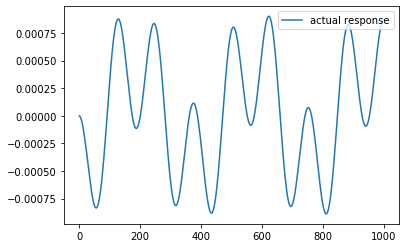

In [26]:
#plt.plot(response.real, label='response predicted')
plt.plot(sys.p_average, label='actual response')
plt.legend()
plt.show()

In [25]:
reconstructed.C

array([[-0.00130447,  0.04690172, -0.01799867, -0.00253109, -0.00539536]])